# Train SNDL Model
This notebook will develop and train a neural network to predict the percent change in the SNDL price.
It will utilize grid search to find the best hyperparameters

## Enviornment setups

In [1]:
# Import packages

# General Utility
from datetime import datetime
import datetime, time
from datetime import timedelta

# Data processing
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import RobustScaler

# Plotting
import matplotlib.pyplot as plt

import torch

# Diamond-Hands
import sys
sys.path.append('../Packages/')
import diamond_hands as dh

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
tickr = 'SNDL'

In [3]:
# Data Locations
processed_input_dir = '../../Data/ProcessedInputs/'
model_dir = '../../Data/Models/'
grid_result_dir = model_dir+tickr+'/'
fine_grid_result_dir = model_dir+tickr+'/Fine/'
pred_dir = '../../Data/Predictions/'
final_model_dir = '../../Data/Models/Final/'

In [4]:
TRAIN_ON_GPU, TRAIN_ON_MULTI_GPUS = dh.setupPytorch()

Training on 4 GPUs!


In [5]:
with open(processed_input_dir+tickr+'_input_data.bin','rb') as f:
    df = pickle.load(f)
with open(processed_input_dir+tickr+'_output_data.bin','rb') as f:
    output_data = pickle.load(f)
with open(model_dir+tickr+'_scaler.bin','rb') as f:
    scaler = pickle.load(f)

In [6]:
df = df[:-1]

In [7]:
df['2021-03-01':]

,P_Change,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,volume_nvi,...,Tomorrow_Tickr_#Pos,Tomorrow_Tickr_W#Neg,Tomorrow_Tickr_W#Neu,Tomorrow_Tickr_W#Pos,Tomorrow_Tickr_%Neg,Tomorrow_Tickr_%Neu,Tomorrow_Tickr_%Pos,Tomorrow_Tickr_W%Neg,Tomorrow_Tickr_W%Neu,Tomorrow_Tickr_W%Pos
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-01,-0.123354,-18.702145,64.914600,0.838584,37.301673,0.722519,0.000820,0.019179,-12.802023,-0.251350,...,34.0,5.0,214.0,105.0,0.042553,0.595745,0.361702,0.011261,0.481982,0.236486
2021-03-02,0.096323,-19.732931,70.224699,0.439546,33.966607,0.681082,0.007004,0.018444,34.893929,-0.251350,...,41.0,55.0,286.0,170.0,0.062992,0.614173,0.322835,0.079595,0.413893,0.246020
2021-03-03,-0.925560,-20.195292,67.269769,0.397594,26.146888,0.346008,-0.012199,0.014820,-10.446091,-0.251766,...,10.0,11.0,52.0,43.0,0.100000,0.400000,0.500000,0.091667,0.433333,0.358333
2021-03-04,-0.287470,-20.559352,62.709452,0.433706,14.403538,-0.644177,-0.017321,0.011380,-130.451607,-0.251766,...,5.0,18.0,57.0,28.0,0.153846,0.653846,0.192308,0.141732,0.448819,0.220472
2021-03-05,-0.217458,-19.407801,57.401673,0.598641,10.678694,-0.425280,-0.015806,0.013937,-119.239637,-0.251766,...,3.0,13.0,97.0,6.0,0.157895,0.684211,0.157895,0.103175,0.769841,0.047619
2021-03-08,1.125432,-18.972671,60.775844,0.678007,11.053314,-0.740994,0.013046,0.014175,3.873918,-0.251498,...,6.0,11.0,18.0,27.0,0.083333,0.416667,0.500000,0.196429,0.321429,0.482143
2021-03-09,1.719653,-18.037371,65.956323,0.567351,23.110393,-0.497575,0.025163,0.016331,208.050602,-0.251498,...,17.0,1.0,157.0,111.0,0.095238,0.500000,0.404762,0.003195,0.501597,0.354633
2021-03-10,-0.622032,-18.771919,61.136670,0.319049,14.971231,-0.449948,0.007107,0.018079,127.043635,-0.251903,...,9.0,14.0,39.0,33.0,0.150000,0.400000,0.450000,0.162791,0.453488,0.383721
2021-03-11,0.172862,-17.381122,65.284656,-0.539555,18.549588,-0.068668,0.002371,0.018737,14.025825,-0.251347,...,16.0,12.0,213.0,103.0,0.073171,0.536585,0.390244,0.035503,0.630178,0.304734


In [8]:
n_test=37

## Grid Search

In [9]:
# Configure search space
n_features = [df.shape[1]]
n_periods = [1,5,10,20,40,60]
n_hidden = [10,50,100]
n_layers = [2,3]
drop_prob = [0.1,0.25,0.5]
lr = [0.001,0.01]
clip = [1,5,10]
batch_size = [400]

In [10]:
# use grid search to optimize hyperparameters
grid_result = []
dh.gridSearch(grid_results = grid_result,
              tickr=tickr,
                           n_features=n_features,
                           n_periods=n_periods,
                           n_hidden=n_hidden,
                           n_layers=n_layers,
                           drop_prob=drop_prob,
                           lr=lr,
                           clip=clip,
                           batch_size=batch_size,
                           data=df,
                           epochs=10,
                           n_test=n_test,
                           n_steps_out=1,
                          fpath=grid_result_dir,
                           TRAIN_ON_GPU=TRAIN_ON_GPU,
                           TRAIN_ON_MULTI_GPUS=TRAIN_ON_MULTI_GPUS)

Hyper Parameter search across 648 different configurations.
Iteration: 1 |periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1


C:\Environments\python37\lib\site-packages\torch\cuda\nccl.py:16: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Training complete in 0m 34s
Iteration: 2 |periods: 5|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 3 |periods: 10|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 3s
Iteration: 4 |periods: 20|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 3s
Iteration: 5 |periods: 40|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 4s
Iteration: 6 |periods: 60|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 5s
Iteration: 7 |periods: 1|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 8 |periods: 5|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 9 |periods: 10|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 10 |periods: 20|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 3s
Iteration: 11 |periods: 40|hidden: 50|layers: 2|drop: 0.

Training complete in 0m 2s
Iteration: 82 |periods: 20|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 3s
Iteration: 83 |periods: 40|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 4s
Iteration: 84 |periods: 60|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 5s
Iteration: 85 |periods: 1|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 86 |periods: 5|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 87 |periods: 10|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 88 |periods: 20|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 3s
Iteration: 89 |periods: 40|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 4s
Iteration: 90 |periods: 60|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 5s
Iteration: 91 |periods: 1|hidden: 10|layer

Training complete in 0m 4s
Iteration: 162 |periods: 60|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 5s
Iteration: 163 |periods: 1|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 2s
Iteration: 164 |periods: 5|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 3s
Iteration: 165 |periods: 10|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 3s
Iteration: 166 |periods: 20|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 4s
Iteration: 167 |periods: 40|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 6s
Iteration: 168 |periods: 60|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 7s
Iteration: 169 |periods: 1|hidden: 50|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 2s
Iteration: 170 |periods: 5|hidden: 50|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 3s
Iteration: 171 |periods: 10|hidden: 50|l

Iteration: 241 |periods: 1|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 2s
Iteration: 242 |periods: 5|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 2s
Iteration: 243 |periods: 10|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 3s
Iteration: 244 |periods: 20|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 4s
Iteration: 245 |periods: 40|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 6s
Iteration: 246 |periods: 60|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 7s
Iteration: 247 |periods: 1|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 2s
Iteration: 248 |periods: 5|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 3s
Iteration: 249 |periods: 10|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 3s
Iteration: 250 |periods: 20|hidden: 100|layers: 3|drop: 0.1|lr: 0

Training complete in 0m 2s
Iteration: 320 |periods: 5|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 3s
Iteration: 321 |periods: 10|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 3s
Iteration: 322 |periods: 20|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 4s
Iteration: 323 |periods: 40|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 6s
Iteration: 324 |periods: 60|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 8s
Iteration: 325 |periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 2s
Iteration: 326 |periods: 5|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 2s
Iteration: 327 |periods: 10|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 2s
Iteration: 328 |periods: 20|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 3s
Iteration: 329 |periods: 40|hidden: 10|

Iteration: 399 |periods: 10|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 2s
Iteration: 400 |periods: 20|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 3s
Iteration: 401 |periods: 40|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 4s
Iteration: 402 |periods: 60|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 5s
Iteration: 403 |periods: 1|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 2s
Iteration: 404 |periods: 5|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 2s
Iteration: 405 |periods: 10|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 2s
Iteration: 406 |periods: 20|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 3s
Iteration: 407 |periods: 40|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 4s
Iteration: 408 |periods: 60|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5

Training complete in 0m 2s
Iteration: 478 |periods: 20|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 3s
Iteration: 479 |periods: 40|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 4s
Iteration: 480 |periods: 60|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 5s
Iteration: 481 |periods: 1|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 2s
Iteration: 482 |periods: 5|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 2s
Iteration: 483 |periods: 10|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 3s
Iteration: 484 |periods: 20|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 3s
Iteration: 485 |periods: 40|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 4s
Iteration: 486 |periods: 60|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 5s
Iteration: 487 

Training complete in 0m 3s
Iteration: 556 |periods: 20|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 3s
Iteration: 557 |periods: 40|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 4s
Iteration: 558 |periods: 60|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 5s
Iteration: 559 |periods: 1|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 2s
Iteration: 560 |periods: 5|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 3s
Iteration: 561 |periods: 10|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 3s
Iteration: 562 |periods: 20|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 4s
Iteration: 563 |periods: 40|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 6s
Iteration: 564 |periods: 60|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 7s
Iteration: 565 |periods: 1|hidden: 5

Training complete in 0m 4s
Iteration: 635 |periods: 40|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 5s
Iteration: 636 |periods: 60|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 7s
Iteration: 637 |periods: 1|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 2s
Iteration: 638 |periods: 5|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 2s
Iteration: 639 |periods: 10|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 3s
Iteration: 640 |periods: 20|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 4s
Iteration: 641 |periods: 40|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 5s
Iteration: 642 |periods: 60|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 7s
Iteration: 643 |periods: 1|hidden: 100|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 2s
Iteration: 644 |periods: 5|hidden: 100|

In [11]:
with open(model_dir+tickr+'_grid_search_result.bin','wb') as f:
    pickle.dump(grid_result,f)

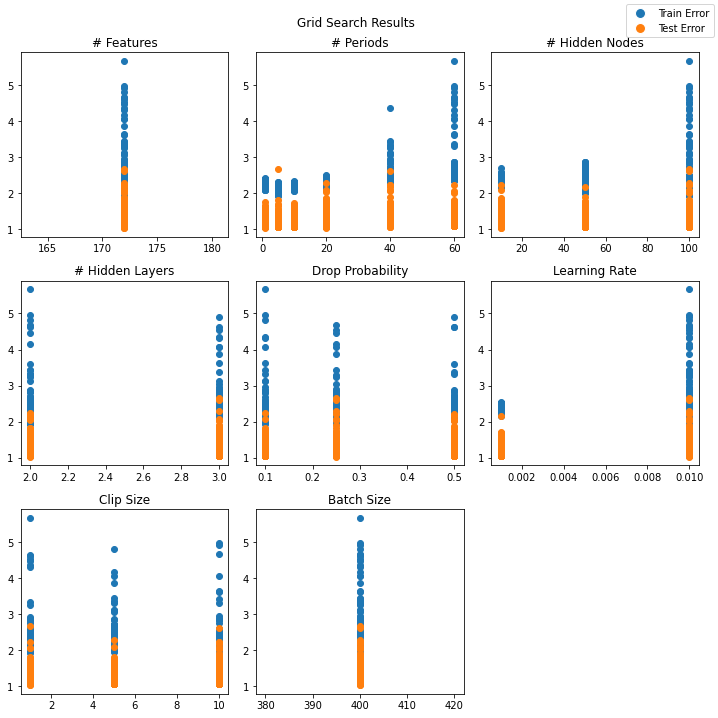

In [12]:
dh.visualizeGridSearch(grid_result)

In [13]:
resultdf = dh.resultDF(grid_result)

In [14]:
sorted_results = resultdf.sort_values(by=['Test Error'])
sorted_results

,Train Error,Test Error,# Features,# Periods,# Hidden Nodes,# Hidden Layers,Drop Probability,Learning Rate,Clip Size,Batch Size
144,2.260599,1.018373,172.0,1.0,10.0,2.0,0.25,0.010,1.0,400.0
3,2.335274,1.039556,172.0,20.0,10.0,2.0,0.10,0.001,1.0,400.0
438,2.286087,1.047058,172.0,1.0,50.0,2.0,0.10,0.001,10.0,400.0
6,2.264097,1.048925,172.0,1.0,50.0,2.0,0.10,0.001,1.0,400.0
222,2.237657,1.050236,172.0,1.0,50.0,2.0,0.10,0.001,5.0,400.0
...,...,...,...,...,...,...,...,...,...,...
629,3.600480,2.216171,172.0,60.0,100.0,2.0,0.50,0.010,10.0,400.0
124,3.328407,2.232274,172.0,40.0,100.0,2.0,0.10,0.010,1.0,400.0
393,2.415611,2.290638,172.0,20.0,100.0,3.0,0.25,0.010,5.0,400.0
610,2.861174,2.607581,172.0,40.0,100.0,3.0,0.25,0.010,10.0,400.0


## Fine Grid Search

In [15]:
best_model_id = sorted_results.index[0]

In [16]:
with open(grid_result_dir+str(best_model_id+1)+'.model','rb') as f:
    model = torch.load(f)
model.eval()


StockLSTM(
  (lstm): LSTM(172, 10, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [17]:
# Configure search space
n_features = [df.shape[1]]
n_periods = [model.n_periods]
n_hidden = [model.n_hidden]
n_layers = [model.n_layers]
drop_prob = [model.drop_prob]
lr = [model.lr]
clip = [model.clip]
#batch_size = [1,5,10,20,40,60,120,240]
batch_size = [4,20,40,80,240,480,960]
epochs = [10,25,50,100,250,500]

In [18]:
# use fine grid search to optimize hyperparameters
fine_grid_result = []
dh.finegridSearch(grid_results = fine_grid_result,
              tickr=tickr,
                           n_features=n_features,
                           n_periods=n_periods,
                           n_hidden=n_hidden,
                           n_layers=n_layers,
                           drop_prob=drop_prob,
                           lr=lr,
                           clip=clip,
                           batch_size=batch_size,
                           data=df,
                           epochs=epochs,
                           n_test=n_test,
                           n_steps_out=1,
                          fpath=fine_grid_result_dir,
                           TRAIN_ON_GPU=TRAIN_ON_GPU,
                           TRAIN_ON_MULTI_GPUS=TRAIN_ON_MULTI_GPUS)

Hyper Parameter search across 42 different configurations.
Iteration: 1 |epochs: 10|periods: 1|hidden: 10|layers: 2|drop: 0.25|lr: 0.01|clip: 1


C:\Environments\python37\lib\site-packages\torch\cuda\nccl.py:16: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Training complete in 1m 27s
Iteration: 2 |epochs: 10|periods: 1|hidden: 10|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 18s
Iteration: 3 |epochs: 10|periods: 1|hidden: 10|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 9s
Iteration: 4 |epochs: 10|periods: 1|hidden: 10|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 5s
Iteration: 5 |epochs: 10|periods: 1|hidden: 10|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 3s
Iteration: 6 |epochs: 10|periods: 1|hidden: 10|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 2s
Iteration: 7 |epochs: 10|periods: 1|hidden: 10|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 2s
Iteration: 8 |epochs: 25|periods: 1|hidden: 10|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 3m 38s
Iteration: 9 |epochs: 25|periods: 1|hidden: 10|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 48s
Iteration: 10 |epochs: 25|periods: 1|hidden: 10|layers: 2|drop: 0.25|lr: 

In [19]:
with open(model_dir+tickr+'fine_grid_search_result.bin','wb') as f:
    pickle.dump(fine_grid_result,f)

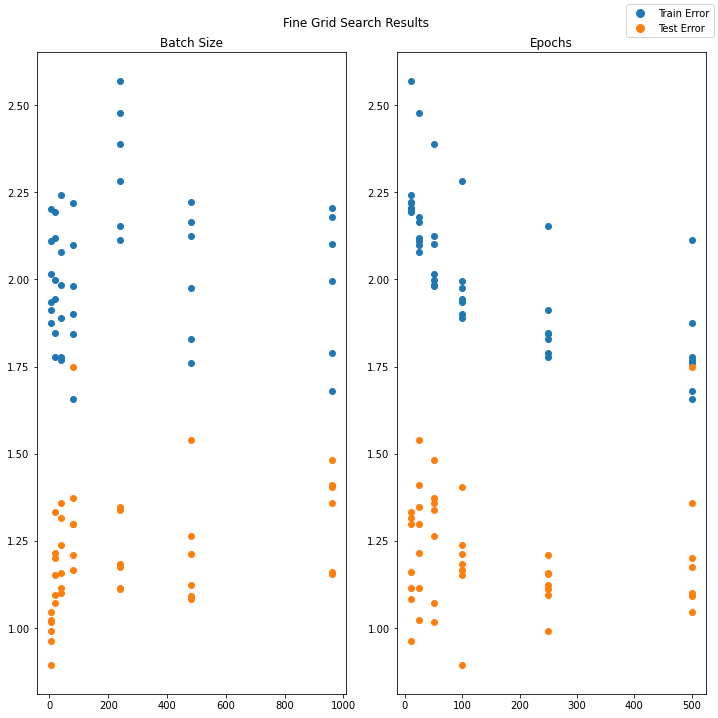

In [20]:
dh.visualizeFineGridSearch(fine_grid_result)

In [21]:
resultdf = dh.resultDFFine(fine_grid_result)

In [22]:
sorted_results = resultdf.sort_values(by=['Test Error'])
sorted_results

,Train Error,Test Error,# Features,# Periods,# Hidden Nodes,# Hidden Layers,Drop Probability,Learning Rate,Clip Size,Batch Size,Epochs
21,1.935987,0.894838,172.0,1.0,10.0,2.0,0.25,0.01,1.0,4.0,100.0
0,2.200902,0.962895,172.0,1.0,10.0,2.0,0.25,0.01,1.0,4.0,10.0
28,1.911215,0.991076,172.0,1.0,10.0,2.0,0.25,0.01,1.0,4.0,250.0
14,2.015256,1.017745,172.0,1.0,10.0,2.0,0.25,0.01,1.0,4.0,50.0
7,2.109623,1.024279,172.0,1.0,10.0,2.0,0.25,0.01,1.0,4.0,25.0
35,1.873912,1.045330,172.0,1.0,10.0,2.0,0.25,0.01,1.0,4.0,500.0
15,1.999259,1.072555,172.0,1.0,10.0,2.0,0.25,0.01,1.0,20.0,50.0
5,2.220535,1.082815,172.0,1.0,10.0,2.0,0.25,0.01,1.0,480.0,10.0
40,1.759992,1.090935,172.0,1.0,10.0,2.0,0.25,0.01,1.0,480.0,500.0
29,1.845863,1.093193,172.0,1.0,10.0,2.0,0.25,0.01,1.0,20.0,250.0


## Evaluate Final Model

In [23]:
best_model_id = sorted_results.index[0]
with open(fine_grid_result_dir+str(best_model_id+1)+'.model','rb') as f:
    model = torch.load(f)
model.eval()

StockLSTM(
  (lstm): LSTM(172, 10, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

Training RMSE: 0.2501434611136912
Test RMSE: 0.12245344455715508
Training MAE: 0.11811115620942501
Test MAE: 0.09257214222985373
Training - Above Error: $0.13 (46.84%) Below Error: $-0.10 (53.16%)
Test - Above Error: $0.12 (29.73%) Below Error: $-0.08 (70.27%)


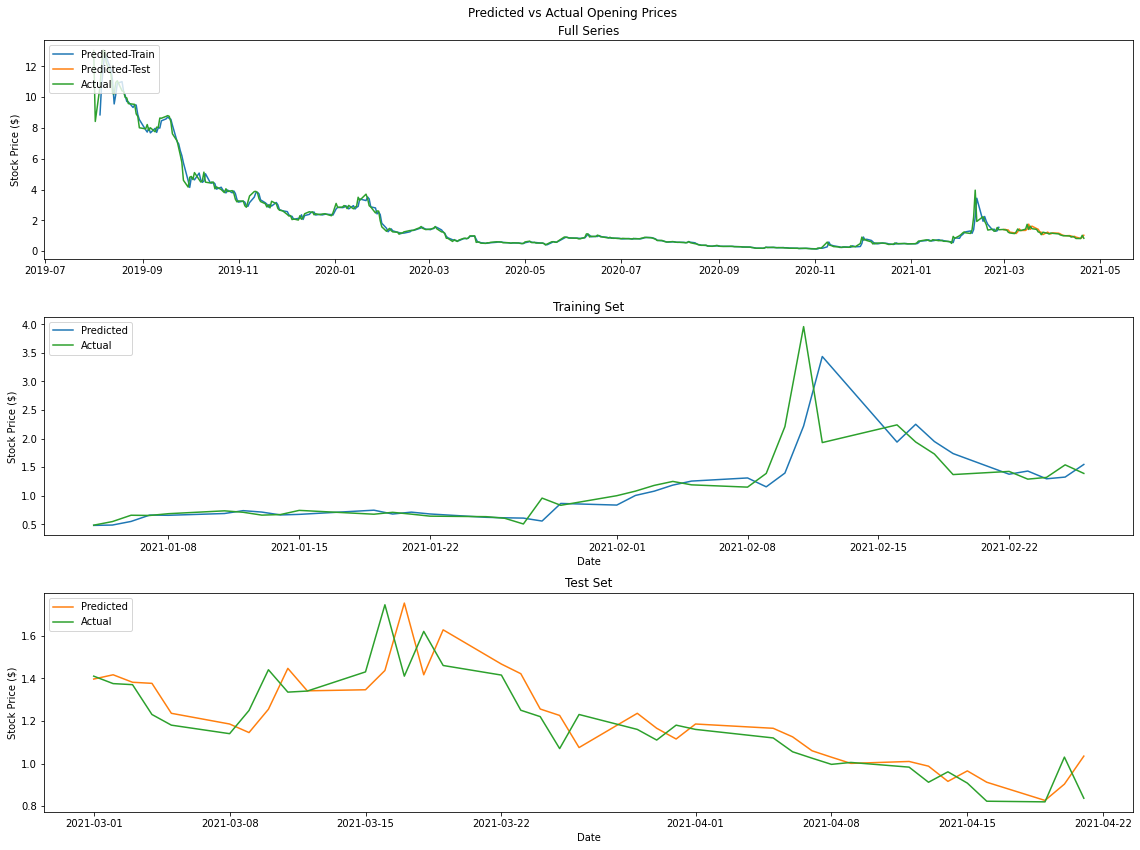

In [24]:
preds = dh.evaluateModel(model=model,
             input_data=df,
             output_data=output_data[:-1],
             scaler=scaler,
             n_steps_in=model.n_periods,
             n_steps_out=1,
             n_test=n_test)

In [25]:
preds.tail()

,Open,Raw_Predictions,Prediction_Type,Predicted
Date,,,,
2021-04-15,0.908,0.00455,Test,0.965372
2021-04-16,0.823,0.00455,Test,0.912131
2021-04-19,0.820,0.10146,Test,0.826744
2021-04-20,1.030,0.00455,Test,0.903197
2021-04-21,0.837,0.00455,Test,1.034686


In [26]:
with open(pred_dir+tickr+'_pred.bin','wb') as f:
    pickle.dump(preds,f)

In [27]:
with open(final_model_dir+tickr+'_model.model','wb') as f:
    torch.save(model,f)